In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import math

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1000

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 67321904.90it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import random
from torch import linalg

In [ ]:
import numpy as np

set_ = {0,    1,    2,    3,    4,    32,   33,   34,   35,   36,   64,   65,   66,   67,   68,   96,   97,   98,   99,   100,  128,  129,  130,  131,  132,
        1024, 1025, 1026, 1027, 1028, 1056, 1057, 1058, 1059, 1060, 1088, 1089, 1090, 1091, 1092, 1120, 1121, 1122, 1123, 1124, 1152, 1153, 1154, 1155, 1156,
        2048, 2049, 2050, 2051, 2052, 2080, 2081, 2082, 2083, 2084, 2112, 2113, 2114, 2115, 2116, 2144, 2145, 2146, 2147, 2148, 2176, 2177, 2178, 2179, 2180}
matrix = []

# Create the first row
row = np.array([1 if i in set_ else 0 for i in range(3072)])
matrix.append(row)

# Create the remaining 783 rows
for j in range(783):
    row_shifted = np.array([1 if (i - j - 1) in set_ else 0 for i in range(len(matrix[-1]))])
    matrix.append(row_shifted)

# Convert the list of lists (matrix) to a NumPy array
mask = np.array(matrix)
mask = torch.tensor(mask)
#mask = torch.cat((mask, mask), dim=0)

print(type(mask))
print(mask.size())

<class 'torch.Tensor'>
torch.Size([784, 3072])


In [ ]:

class Net(nn.Module):
    def __init__(self,q):
       super().__init__()
       self.fc0 = nn.Linear(3072, 1 * 28 * 28)
       #self.dropout0 = nn.Dropout(0.5)
       self.fc1 = nn.Linear(1 * 28 * 28, 120)
       self.fc2 = nn.Linear(120, 84)
       self.fc3 = nn.Linear(84, 10)
       self.q = q
       self.additional_params = nn.ParameterList()
       self.additional_params.append(torch.cat((self.initialize_random_probability_vector(q),self.initialize_random_probability_vector(q),self.initialize_random_probability_vector(q)), dim=-1))
       for _ in range(783):
           new_row = nn.Parameter(torch.cat((self.initialize_random_probability_vector(q), self.initialize_random_probability_vector(q), self.initialize_random_probability_vector(q)), dim=-1))
           self.additional_params.append(new_row)



    def initialize_random_probability_vector(self, q):
        # Generate q random numbers between 0 and 1
        random_vector = np.random.rand(q)

        # Normalize the vector to make it a valid probability distribution
        probability_vector = random_vector / np.sum(random_vector)

        return torch.tensor(probability_vector)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc0(x))
        #x = self.dropout0(x)
        penalty_term = 0
        for i in range(784):
          left1 = 0
          right1 = math.floor(int(1024*self.additional_params[i][0])) - 1
          sum1 = (1024*self.additional_params[i][0]) * torch.norm(self.fc0.weight[i][left1:right1])
          for j in range(1, self.q):
            left1 += math.floor(int(1024*self.additional_params[i][j-1]))
            right1 += math.floor(int(1024*(self.additional_params[i][j]))) - 1
            sum1 += (1024*self.additional_params[i][j]) * torch.norm(self.fc0.weight[i][left1:right1])

          left2 = 1024
          right2 = math.floor(int(1024*self.additional_params[i][10])) - 1
          sum2 = (1024*self.additional_params[i][10]) * torch.norm(self.fc0.weight[i][left2:right2])
          for j in range(11,self.q+10):
            left2 += math.floor(int(1024*self.additional_params[i][j-1]))
            right2 += math.floor(int(1024*self.additional_params[i][j])) - 1
            sum2 += (1024*self.additional_params[i][j]) * torch.norm(self.fc0.weight[i][left2:right2])

          left3 = 2048
          right3 = math.floor(int(1024*self.additional_params[i][20])) - 1
          sum3 = (1024*self.additional_params[i][20]) * torch.norm(self.fc0.weight[i][left3:right3])
          for j in range(21,self.q+20):
            left3 += math.floor(int(self.additional_params[i][j-1]))
            right3 += math.floor(int(1024*(self.additional_params[i][j]-1)))
            sum3 += (1024*self.additional_params[i][j]) * torch.norm(self.fc0.weight[i][left3:right3])

          penalty_term += (sum1 + sum2 + sum3)
          print('penalty:', penalty_term)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x,penalty_term

net = Net(10)

In [ ]:
 import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs[0], labels) + outputs[1]
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 1:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     2] loss: 9.259
[1,     7] loss: -0.097
[1,    12] loss: -81.730
[1,    17] loss: -350.029
[1,    22] loss: -7.135


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs[0].data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
#47

tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+10, dtype=torch.float64)
tensor(-2.1281e+

Parameter containing:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], requires_grad=True)


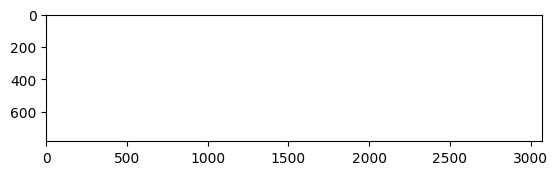

In [ ]:
import matplotlib.pyplot as plt

# Assuming net.fc0.weight is the PyTorch tensor causing the issue
tensor_to_plot = (net.fc0.weight).detach().numpy()
print(net.fc0.weight)

plt.imshow(tensor_to_plot, cmap='gray')
plt.show()